In [44]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
import nltk
import os
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [45]:
df = pd.read_csv("twitter_training.csv", header=None)
df.columns = ['entity', 'sentiment', 'unused', 'text']
df.drop(columns=['unused'], inplace=True)

# Clean text function (light)
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'@\w+|\#', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['clean_text'] = df['text'].apply(clean_text)

# Show unique sentiment labels
print("Unique Sentiment Labels Found:", df['sentiment'].unique())
print("\nSample Rows:\n", df[['sentiment', 'text']].head())



Unique Sentiment Labels Found: ['Borderlands' 'CallOfDutyBlackopsColdWar' 'Amazon' 'Overwatch'
 'Xbox(Xseries)' 'NBA2K' 'Dota2' 'PlayStation5(PS5)' 'WorldOfCraft'
 'CS-GO' 'Google' 'AssassinsCreed' 'ApexLegends' 'LeagueOfLegends'
 'Fortnite' 'Microsoft' 'Hearthstone' 'Battlefield'
 'PlayerUnknownsBattlegrounds(PUBG)' 'Verizon' 'HomeDepot' 'FIFA'
 'RedDeadRedemption(RDR)' 'CallOfDuty' 'TomClancysRainbowSix' 'Facebook'
 'GrandTheftAuto(GTA)' 'MaddenNFL' 'johnson&johnson' 'Cyberpunk2077'
 'TomClancysGhostRecon' 'Nvidia']

Sample Rows:
      sentiment                                               text
0  Borderlands  im getting on borderlands and i will murder yo...
1  Borderlands  I am coming to the borders and I will kill you...
2  Borderlands  im getting on borderlands and i will kill you ...
3  Borderlands  im coming on borderlands and i will murder you...
4  Borderlands  im getting on borderlands 2 and i will murder ...


In [46]:
# Get top 3 most frequent sentiments
top_sentiments = df['sentiment'].value_counts().head(3).index.tolist()
print("\nTop 3 Sentiments Auto-Selected:", top_sentiments)

# Filter for modeling
df_model = df[df['sentiment'].isin(top_sentiments)].copy()
df_model['clean_text'] = df_model['clean_text'].fillna('').str.strip()
df_model = df_model[df_model['clean_text'].str.len() > 2]

print(f"Rows remaining after filtering: {len(df_model)}")
df_model[['sentiment', 'clean_text']].head()




Top 3 Sentiments Auto-Selected: ['Microsoft', 'MaddenNFL', 'TomClancysRainbowSix']
Rows remaining after filtering: 7084


,sentiment,clean_text
34926,Microsoft,very good of you to remind us i thought it was...
34927,Microsoft,i thought it was ge but they sold
34928,Microsoft,i thought it was ge but they sold
34929,Microsoft,very good of you to remind anna i thought it w...
34930,Microsoft,very good of you to remind those us i had thou...


/tmp/ipython-input-47-365967874.py:40: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-47-365967874.py:43: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig("plots/sentiment_distribution.png", dpi=300)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


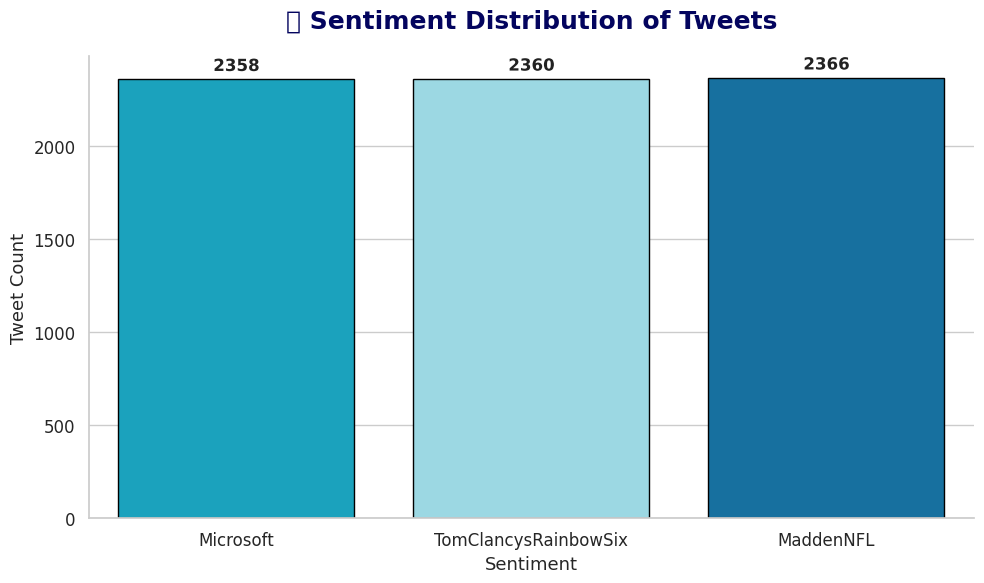

In [47]:
# Create folder if needed
os.makedirs("plots", exist_ok=True)

# Set a custom color palette
custom_palette = ["#00B4D8", "#90E0EF", "#0077B6", "#03045E"]  # Ocean gradient

# Plot aesthetics
sns.set(style="whitegrid", rc={"axes.facecolor": "white", "figure.facecolor": "white"})
plt.figure(figsize=(10, 6))

# Draw bar plot
ax = sns.countplot(data=df_model, x='sentiment', palette=custom_palette, edgecolor='black')

# Add rounded tops and shadow effect
for p in ax.patches:
    count = int(p.get_height())
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()

    # Value label with drop shadow
    ax.annotate(f'{count}',
                xy=(x, y),
                xytext=(0, 6),
                textcoords="offset points",
                ha='center',
                fontsize=12,
                fontweight='bold',
                color='#222',
                path_effects=[pe.withStroke(linewidth=3, foreground="white")])

# Titles and labels
plt.title("📊 Sentiment Distribution of Tweets", fontsize=18, fontweight='bold', pad=20, color="#03045E")
plt.xlabel("Sentiment", fontsize=13, fontweight='medium')
plt.ylabel("Tweet Count", fontsize=13, fontweight='medium')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Remove clutter
sns.despine()
plt.tight_layout()

# Save high-res version
plt.savefig("plots/sentiment_distribution.png", dpi=300)
plt.show()

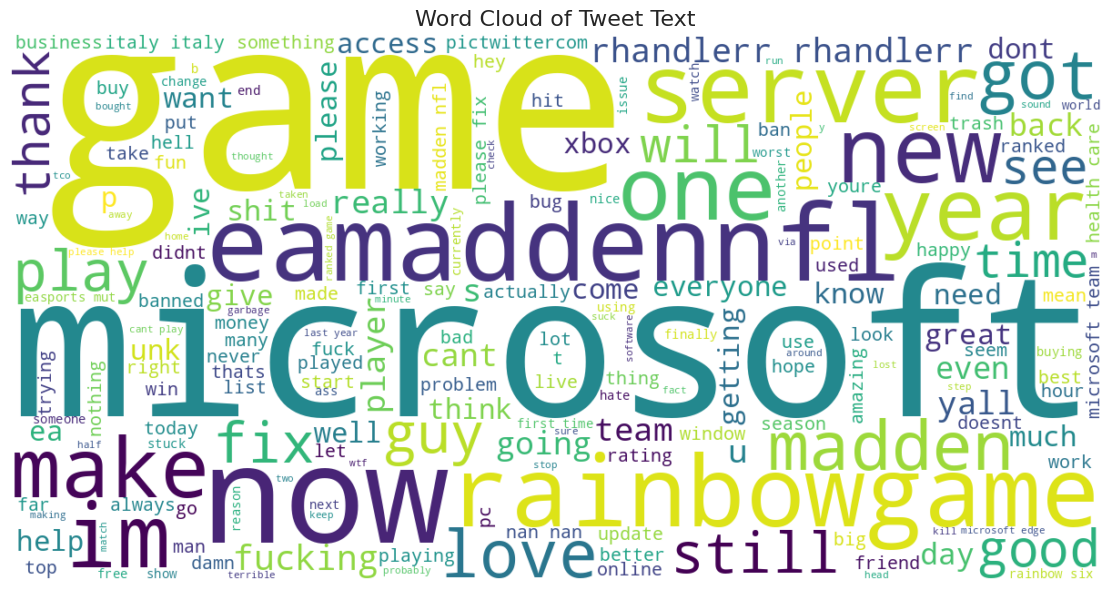

In [35]:
all_words = ' '.join(df_model['clean_text'])
wordcloud = WordCloud(width=1200, height=600, background_color='white', colormap='viridis').generate(all_words)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Tweet Text", fontsize=16)
plt.tight_layout()
plt.savefig("plots/tweet_wordcloud.png", dpi=300)
plt.show()


In [36]:
X = df_model['clean_text']
y = df_model['sentiment']

vectorizer = TfidfVectorizer()
X_vec = vectorizer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


                      precision    recall  f1-score   support

           MaddenNFL       0.95      0.93      0.94       487
           Microsoft       0.96      0.92      0.94       485
TomClancysRainbowSix       0.90      0.96      0.93       445

            accuracy                           0.94      1417
           macro avg       0.94      0.94      0.93      1417
        weighted avg       0.94      0.94      0.94      1417



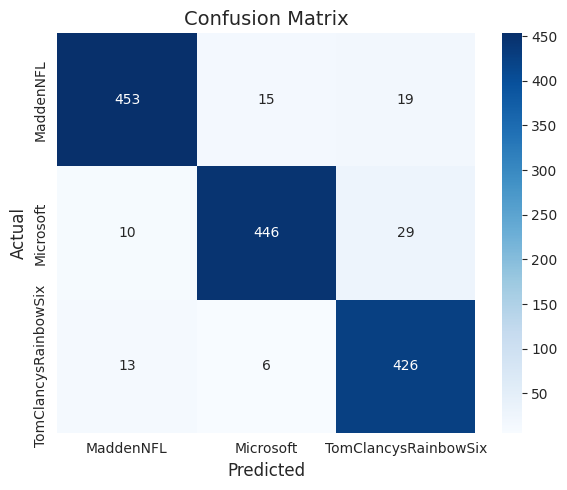

In [37]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)
plt.tight_layout()
plt.savefig("plots/confusion_matrix.png", dpi=300)
plt.show()


In [38]:
def predict_sentiment(text):
    cleaned = clean_text(text)
    vec = vectorizer.transform([cleaned])
    return model.predict(vec)[0]

# Try your own tweet
your_tweet = "I absolutely love this product! Works perfectly."
print("Predicted Sentiment:", predict_sentiment(your_tweet))


Predicted Sentiment: MaddenNFL
